<font size=25, color='#ED1F24'>Assigment 2 - Convolutional Networks

Import necessary libraries

In [90]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from random import sample

from IPython.core.debugger import set_trace

import sklearn


Set the parameters for training

In [2]:
lr = 0.001
momentum = 0.9
num_epochs = 5
batch_size = 8
num_cls = 10

Load **CIFAR-10** dataset

In [69]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./ds', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [0.8, 0.2])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./ds', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

assert len(trainset) == 40000
assert len(valset) == 10000
assert len(testset) == 10000

# **TASK 1**. Classification task

## **Task 1.1** Define a standard convolutional network

In [153]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5), padding=2) #P = (F-1)/2
        self.activation_fn = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5), padding=2) 
        self.fc1 = nn.Linear(in_features=16*8*8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=out_size)
        # TODO

    def forward(self, x):
        #TODO
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = self.activation_fn(x)
        x = self.fc3(x)
        return x

net = SimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

## **Task 1.2.** Training and evaluation

In [154]:
def validate(model, loss_fn, device):
    model.eval()
    y_pred = []
    y_true = []
    total_loss = 0
    n_predictions = 0

    with torch.no_grad():
        for X, y in validloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            
            batch_size = X.size(0)
            total_loss += loss.item() * batch_size
            n_predictions += batch_size
            
            outputs = torch.argmax(outputs, dim=1)
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y.cpu().numpy())
    
    average_loss = total_loss / n_predictions
    return y_pred, y_true, average_loss, sklearn.metrics.accuracy_score(y_true, y_pred)

In [155]:
def train_epoch(model, optimizer, loss_fn, device):
    model.train()
    y_true = []
    y_pred = []
    total_loss = 0
    n_predictions = 0

    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        outputs = model(X)
        loss = loss_fn(outputs, y)
        
        loss.backward()
        optimizer.step()
        
        batch_size = X.size(0)
        total_loss += loss.item() * batch_size
        n_predictions += batch_size
        
        outputs = torch.argmax(outputs, dim=1)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y.cpu().numpy())
    
    average_loss = total_loss / n_predictions
    
    _, _, val_loss, val_accuracy = validate(model, loss_fn, device)
    
    return average_loss, sklearn.metrics.accuracy_score(y_true, y_pred), val_loss, val_accuracy

In [156]:
def train_loop(n_epochs, net, optimizer, loss_fn):
    hist_train_loss = []
    hist_train_acc = []
    hist_val_loss = []
    hist_val_acc = []
    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc = train_epoch(net, optimizer, loss_fn, device)
        print(f'Tran loss = {train_loss} | train acc = {train_acc} | val loss = {val_loss} | val acc = {val_acc}')
        hist_train_loss.append(train_loss)
        hist_train_acc.append(train_acc)
        hist_val_loss.append(val_loss)
        hist_val_acc.append(val_acc)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist_train_loss, label='Training Loss')
    plt.plot(hist_val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(hist_train_acc, label='Training Accuracy')
    plt.plot(hist_val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Tran loss = 1.9404444083690644 | train acc = 0.280925 | val loss = 1.5563052790164948 | val acc = 0.4258
Tran loss = 1.4223626999437808 | train acc = 0.484125 | val loss = 1.3071738960266113 | val acc = 0.5279
Tran loss = 1.2011105140209197 | train acc = 0.572825 | val loss = 1.1234547350406647 | val acc = 0.6058
Tran loss = 1.0495349202096462 | train acc = 0.63095 | val loss = 1.031836933362484 | val acc = 0.6473
Tran loss = 0.9409173274934292 | train acc = 0.6686 | val loss = 1.0217762079894543 | val acc = 0.6476


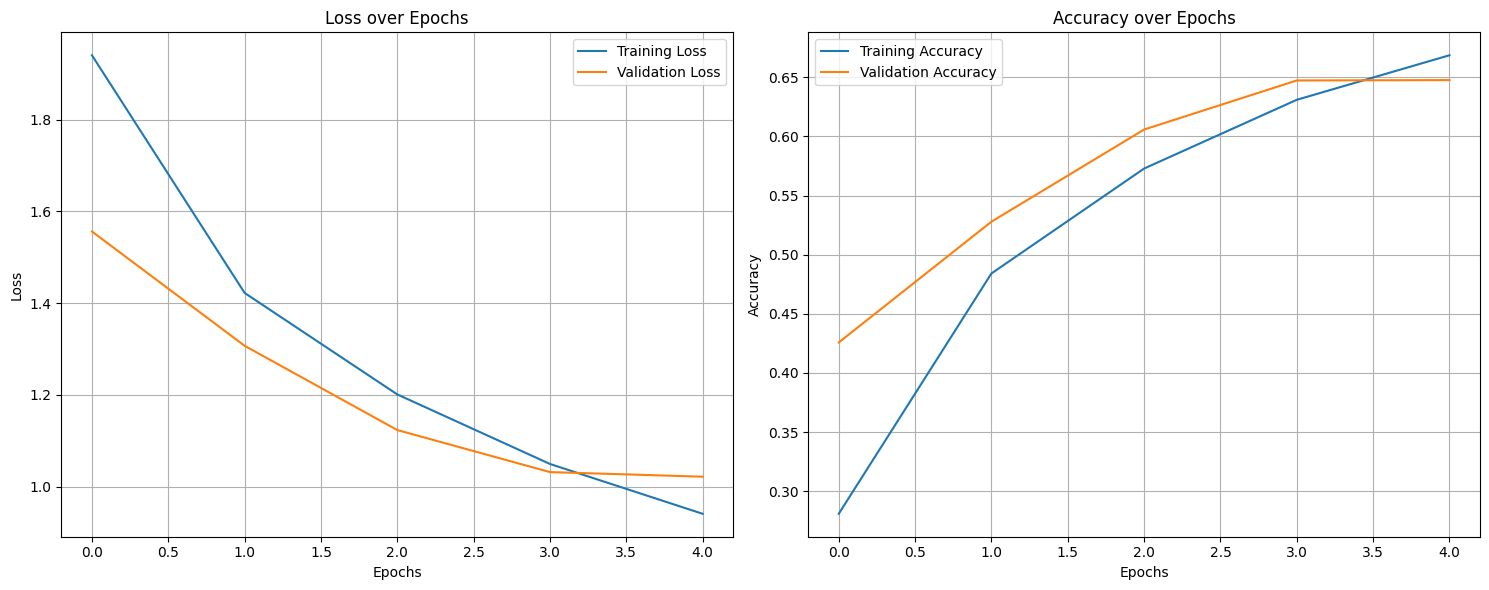

In [157]:
optimizer = torch.optim.SGD(params= net.parameters(), lr=lr, momentum=momentum)
loss_fn = torch.nn.CrossEntropyLoss()

train_loop(num_epochs, net, optimizer, loss_fn)

# **TASK 2**. Implement a fully connected layer

## **Task 2.1.** Implement Linear layer

In [234]:
import math
import pdb
class myLinear(nn.Module):
    def __init__(self, in_features, out_features, device=None):
        super().__init__()
        self.in_features = in_features # 8 
        self.out_features = out_features # 16
        # initialise parameters
        # weight shape: [in, out]
        # bias shape: [out]
        
        self.weight = torch.nn.parameter.Parameter(
            torch.empty(out_features, in_features)
        )
        self.bias = torch.nn.parameter.Parameter(
            torch.empty(out_features)
        )
        
        self.reset_parameters()
    
    def reset_parameters(self):
        self.scale = 1.0 / math.sqrt(self.in_features)
        nn.init.uniform(self.weight, -self.scale, self.scale)
        nn.init.uniform_(self.bias, -self.scale, self.scale)

    def forward(self, x):
    # weight shape: [out, in]
    # x shape: [batch, in]
    # we want do matrix multiplication between the weight and each element in the batch x[i] (seen as a column vector)
    # y[i] = W x[i]
    
    # in order to do this we rely on broadcasting in torch.matmul and must reshape x as [batch, in , 1]
    # such that the matrix multiplication is done on dimmensions [out, in] [in, 1] -> [out, 1]
    # (https://pytorch.org/docs/stable/generated/torch.matmul.html)
        x = torch.reshape(x, (x.size(0), x.size(1), 1))

    # TODO
    # compute the linear operation using torch.matmul
    # y = ...
        y = torch.matmul(self.weight, x)
    
    # we add the same bias column vector to each element in the batch y[i] = y[i] + bias
    # we rely again on broadcasting and make the bias have dimension [1, out, 1]
    # such that it aligns with y of shape [batch, out, 1]
        bias_reshaped = torch.reshape(self.bias, (1, self.out_features, 1))
    
    # TODO add bias
    # y = ...
        y = y + bias_reshaped
        return y.squeeze() # so that it is (batch_size, out_features) and not (batch_size, out_features, 1)


In [235]:
my_linear = myLinear(8, 16)
linear = nn.Linear(8, 16)
my_linear.load_state_dict(linear.state_dict())

C:\Users\Fabi\AppData\Local\Temp\ipykernel_23180\947790645.py:23: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(self.weight, -self.scale, self.scale)


<All keys matched successfully>

In [236]:
input_tensor = torch.rand((batch_size, 8))
output_linear = linear.forward(input_tensor)
output_my_linear = my_linear.forward(input_tensor)

In [237]:
diff = output_linear - output_my_linear
diff.sum()

tensor(0., grad_fn=<SumBackward0>)

# **TASK 3.** Implement a convolutional layer

## **Task 3.1.** Implement Conv2d layer

In [261]:
class myConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, device=None):
        super(myConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        
        # initialise parameters
        scale = 1.0 / math.sqrt(in_channels * kernel_size * kernel_size)
        self.weight = torch.nn.parameter.Parameter(
            torch.rand(out_channels, in_channels, kernel_size, kernel_size)
        )
        self.bias = torch.nn.parameter.Parameter(
            torch.rand(out_channels)
        )
        
        self.reset_parameters()

    def reset_parameters(self):
        self.scale = 1.0 / math.sqrt(self.in_channels * self.kernel_size * self.kernel_size )
        nn.init.uniform(self.weight, -self.scale, self.scale)
        nn.init.uniform_(self.bias, -self.scale, self.scale)

    def forward(self, x):
        print(x.shape)
        x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding), 'constant', 0)
        print(x.shape)

        
        
        # TODO
        
        return out


In [262]:
conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5), padding=2)
my_conv = myConv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2)
input_image = torch.rand((8, 3, 32, 32))
output_conv = conv.forward(input_image)

C:\Users\Fabi\AppData\Local\Temp\ipykernel_23180\584813621.py:22: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(self.weight, -self.scale, self.scale)


In [263]:
output_conv.shape

torch.Size([8, 8, 32, 32])

In [264]:
my_conv.forward(input_image)

torch.Size([8, 3, 32, 32])
torch.Size([8, 3, 36, 36])


NameError: name 'out' is not defined

## **Task 3.2.** Evaluate your implementation of convolutional network.

In [ ]:

class mySimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = # TODO


    def forward(self, x):
        x = # TODO
        return x


my_net = mySimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_net = my_net.to(device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


## **Task 3.3.** Feature map visualization